In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler

import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, models, transforms

# Transferència de coneixement

L'objectiu d'avui és aprendre com podem emprar arquitectures ja existents per resoldre els nostres problemes. 

Com objectius secundaris tenim:

1. Conèixer un nou conjunt de dades
2. Entendre en profunditat com és una de les arquitecures més famoses.
3. Guardar i carregar xarxes neuronals

## Dades

El conjunt de dades [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) consta de 60.000 imatges en color de 32x32 pixels etiquetades en 10 classes, amb 6.000 imatges per classe. Hi ha 50.000 imatges d'entrenament i 10.000 imatges de _test_.

### Feina a fer:

1. Adaptar la mateixa xarxa que vareu desenvolupar la setmana anterior per emprar aquest conjunt de dades. `Grayscale` és una funció que transforma imatges a escala de grisos, la podem emprar dins la nostra composició de transformacions.

Si voleu normalitzar les dades, a continuació teniu els valors ja calculats:

  - mitjana: (0.4914, 0.4822, 0.4465)
  - desviació típica: (0.247, 0.243, 0.261)

Una altra funció que pot ser útil és `Resize(mida_desti)` que rep un enter com a paràmetre (la mida final).


In [10]:
train_batch_size = 64
test_batch_size = 100

# Definim una seqüència (composició) de transformacions 
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)), # mitjana, desviacio tipica
    transforms.Resize(256)
    ])

# Descarregam un dataset ja integrat en la llibreria Pytorch
train = datasets.CIFAR10('../data', train=True, download=True, transform=transform)
test = datasets.CIFAR10('../data', train=False, transform=transform)

# Transformam les dades en l'estructura necessaria per entrenar una xarxa
train_loader = torch.utils.data.DataLoader(train, train_batch_size)
test_loader = torch.utils.data.DataLoader(test, test_batch_size)

Files already downloaded and verified


In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_1 = nn.Linear(7*7*32, 128) #7 * 7 * 64, 120)
        self.linear_2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        y = self.conv_1(x)
        x = self.max_pool2d(y)
        z = self.conv_2(x)
        x = self.max_pool2d(z)
        x = torch.flatten(x, 1)
        x = self.linear_1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.linear_2(x)

        output = F.log_softmax(x, dim=1)
        return output, y, z

In [12]:
def train(model, device, train_loader, optimizer, epoch, log_interval=100, verbose=True):
    model.train()
    loss_v = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output, _, _ = model(data)
        loss = F.cross_entropy(output, target, reduction='mean')
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0 and verbose:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Average: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), loss.item()/ len(data)))
        loss_v += loss.item()
    loss_v /= len(train_loader.dataset)
    print('\nTrain set: Average loss: {:.4f}\n'.format(loss_v))
    return loss_v

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output,_ , _ = model(data)
            test_loss += F.cross_entropy(output, target, reduction='mean')
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss

In [13]:
use_cuda = True
torch.manual_seed(33)

if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
epochs = 15
lr =0.00001

model = Net().to(device)

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # !!!

print("Parameters ",pytorch_total_params)
optimizer = optim.Adam(model.parameters(), lr=lr)

# Guardam el valor de peèrdua mig de cada iteració (època)
train_l = np.zeros((epochs))
test_l = np.zeros((epochs))

# Bucle d'entrenament
for epoch in range(0, epochs):
    train_l[epoch] = train(model, device, train_loader, optimizer, epoch)
    test_l[epoch]  = test(model, device, test_loader)
#567764

Parameters  207210


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x131072 and 1568x128)

## Transfer learning (Definició de la xarxa)

En aquesta pràctica aplicarem la tècnica de _transfer learning_ a partir d'una de les xarxes més conegudes en el camp de visió per computador: [**AlexNet**](https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf). (ImageNet Classification with Deep Convolutional Neural Network, 2012).

_Pytorch_ ens permet emprar les xarxes més conegudes de manera molt senzilla. [Més informació](https://pytorch.org/vision/stable/models.html).

Per xarxes no tan conegudes podem guardar i carregar els models de manera molt senzilla: [Saving and Loading Models](https://pytorch.org/tutorials/beginner/saving_loading_models.html).

Anem a descarregar-la i a analitzar-la. En aquest cas no només ens baixam la seva arquitectura, també els pesos resultants de l'entrenament.

In [14]:
alex = models.alexnet(weights='DEFAULT')

print("-"*50)
print("Arquitectura AlexNet")
print("-"*50)
print(alex)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\jonny/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth
10.1%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

35.0%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

60.4%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--Noteboo

Hi ha diverses maneres de realitzar aquesta tècnica les dues més conegudes són:

 - **"Congelar"** els pesos de la part d'extracció de característiques i crear un nou classificador. Això implica que només entrenam una part de la xarxa.
 - **Reentrenar tota la xarxa**.

 Per tal d'evitar el reentrenament necessitam canviar el valor de l'atribut  `requires_grad` al valor `False`. Aquest atribut és propietat de cada tensor. Podem recorrer els tensors mitjançant el següent codi:
 ```
for param in alex.features.parameters():
    param.requires_grad = False
 ```

 ### Feina a fer:

 1. Carregar la xarxa AlexNet i seleccionar la part d'extracció de característiques.
 2. Definir un entorn seqüencial on implementarem el classificador de la xarxa.
 3. Realitzar un entrenament i comparar els resultats amb el primer entrenament (xarxa pròpia): comparar rendiment (accuracy) però també temps dedicat a entrenar i nombre de paràmetres.
 4. Provar de guardar la vostra xarxa i tornar-la a carregar. Per classificar una imatge del conjunt de test.

In [15]:
#TODO Congelar
for param in alex.features.parameters():
   param.requires_grad = False

my_net =  nn.Sequential(alex.features, nn.Flatten(1,-1), nn.Linear(12544, 512), nn.Softmax(), nn.Linear(512, 10), nn.Softmax())

## Entrenament

[shhht](https://github.com/tqdm/tqdm) si voleu canviar el resum de l'entrenament per una barra de progrés

In [16]:
def train(model, device, train_loader, optimizer, epoch, log_interval=100, verbose=True):
    
    model.train()

    loss_v = 0

    for batch_idx, (data, target) in enumerate(train_loader):
    
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target, reduction='mean') 
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0 and verbose:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Average: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), loss.item()/ len(data)))
        loss_v += loss.item()

    loss_v /= len(train_loader.dataset)
    print('\nTrain set: Average loss: {:.4f}\n'.format(loss_v))
 
    return loss_v


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='mean') 
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max probability
            correct += pred.eq(target.view_as(pred)).sum().item()
 
  
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return test_loss

In [18]:
use_cuda = True
torch.manual_seed(33)

if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

epochs = 5#¿?
lr = 0.000001#¿?

model = my_net.to(device)

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # !!!

print("Parameters ", pytorch_total_params)
optimizer = optim.Adam(model.parameters(), lr=lr)#¿?

# Guardam el valor de pèrdua mig de cada iteració (època)
train_l = np.zeros((epochs))
test_l = np.zeros((epochs))

# Bucle d'entrenament
for epoch in range(0, epochs):
    train_l[epoch] = train(model, device, train_loader, optimizer, epoch)
    test_l[epoch]  = test(model, device, test_loader)


Parameters  6428170
Train Epoch: 0 [0/50000 (0%)]	Loss: 2.302620, Average: 0.035978


C:\Users\jonny\miniconda3\envs\Soluciones\lib\site-packages\torch\nn\modules\container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train Epoch: 0 [6400/50000 (13%)]	Loss: 2.302201, Average: 0.035972
Train Epoch: 0 [12800/50000 (26%)]	Loss: 2.302356, Average: 0.035974
Train Epoch: 0 [19200/50000 (38%)]	Loss: 2.303329, Average: 0.035990
Train Epoch: 0 [25600/50000 (51%)]	Loss: 2.302071, Average: 0.035970
Train Epoch: 0 [32000/50000 (64%)]	Loss: 2.302792, Average: 0.035981
Train Epoch: 0 [38400/50000 (77%)]	Loss: 2.302298, Average: 0.035973
Train Epoch: 0 [44800/50000 (90%)]	Loss: 2.301694, Average: 0.035964

Train set: Average loss: 0.0360


Test set: Average loss: 0.0230, Accuracy: 1651/10000 (17%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.302103, Average: 0.035970
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.301553, Average: 0.035962
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.301567, Average: 0.035962
Train Epoch: 1 [19200/50000 (38%)]	Loss: 2.302660, Average: 0.035979
Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.301182, Average: 0.035956
Train Epoch: 1 [32000/50000 (64%)]	Loss: 2.302164, Average: 0.035971
Train Epoch: 1 

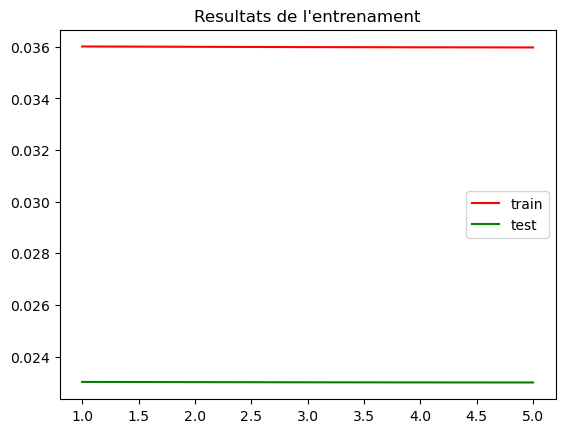

In [19]:
plt.title("Resultats de l'entrenament")
plt.plot(range(1, (epochs + 1)), train_l,  c="red", label="train")
plt.plot(range(1,  (epochs + 1)), test_l,  c="green", label="test")
plt.legend();